# RCNN

**Reference:** https://www.youtube.com/watch?v=IcLEJB2pY2Y&t=2055s

In [ ]:
%config Completer.use_jedi = False    # for autocompletion

In [1]:
import albumentations
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from PIL import Image
from PIL import ImageFile
from pprint import pprint
from tqdm import tqdm

In [75]:
# constants: configurations
if os.path.exists('gen-plate-dataset'):
    DATA_DIR = 'gen-plate-dataset'
else:
    DATA_DIR = os.path.join('..', 'datasets', 'gen-plate-dataset')
BATCH_SIZE = 8
IMAGE_WIDTH = 230
IMAGE_HEIGHT = 50
NUM_WORKERS = 12
DEVICE = 'cuda'  # cpu / cuda
EPOCHS = 100  # in actual initialized 200 but trained till 100

In [76]:
LR = 1e-4

In [77]:
if os.sys.platform=='linux' and os.path.exists('../input/indnumberplate/gen-plate-dataset'):
    DATA_DIR = '../input/indnumberplate/gen-plate-dataset'

In [78]:
DATA_DIR

'../input/indnumberplate/gen-plate-dataset'

# Dataset

In [79]:
# dataset creations

ImageFile.LOAD_TRUNCATED_IMAGES = True


class ClassificationDataset:
    def __init__(self, img_paths, targets, resize=None):
        self.img_paths = img_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [albumentations.Normalize(always_apply=True)])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, item_index):
        img = Image.open(self.img_paths[item_index])
        targets = self.targets[item_index]

        if self.resize is not None:
            img = img.resize((self.resize[1], self.resize[0]),
                             resample=Image.BILINEAR)

        img = np.array(img)
        augmented = self.aug(image = img)
        img = augmented['image']
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        return {
            'imgs': torch.tensor(img, dtype=torch.float),
            'targets': torch.tensor(targets, dtype=torch.long)
        }

# Engine

In [80]:
# engine


def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_fn(model, data_loader, optimizer):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad():
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            batch_preds, loss = model(**data)

            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Model

In [81]:
# model


class PlateRecognizer(nn.Module):
    def __init__(self, num_chars):
        super(PlateRecognizer, self).__init__()
        self.conv1 = nn.Conv2d(3,128, kernel_size=(3, 6), padding=(1, 1))
        self.max_pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1))
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.linear = nn.Linear(768, 64)
        self.drop = nn.Dropout(0.2)  # doesn't change size

        self.gru = nn.GRU(64,
                          32,
                          bidirectional = True,
                          num_layers=2,
                          dropout=0.25,
                          batch_first=True
                         )
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, imgs, targets=None):
        bs, c, w, h = imgs.size()
        # print(bs, c, w, h)    # for debugging
        x = F.relu(self.conv1(imgs))
        # print('Conv1', x.size())
        x = self.max_pool_1(x)
        # print('MaxPool', x.size())
        x = F.relu(self.conv2(x))
        # print('Conv2', x.size())
        x = self.max_pool_2(x)  # 1, 64, 12, 57
        # print('MaxPool', x.size())

        # to brind width first but in our case it's properly arranged
        x = x.permute(0, 3, 1, 2)  # 1, 57, 64, 12
        # print('Permute', x.size())
        x = x.view(bs, x.size(1), -1)
        # print('View', x.size())

        x = self.linear(x)
        x = self.drop(x)
        # print('Linear', x.size())

        x, _ = self.gru(x)
        # print('Recurrent', x.size())

        x = self.output(x)
        # print('output', x.size())

        x = x.permute(1, 0, 2)
        if targets is not None:
            # CTC
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(size=(bs, ),
                                       fill_value=log_probs.size(0),
                                       dtype=torch.int32)
            # print('input lengths', input_lengths)
            target_lengths = torch.full(size=(bs, ),
                                        fill_value=targets.size(1),
                                        dtype=torch.int32)
            # print('target lengths', target_lengths)
            loss = nn.CTCLoss(blank=0)(log_probs, targets,
                                       input_lengths, target_lengths)
            return x, loss

        return x, None

In [82]:
# for debugging model

cm = PlateRecognizer(19)
img = torch.rand(5, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
targets = torch.randint(1, 6, (5, 5))
x, loss = cm(img, targets)

del (cm)

# Train

In [83]:
# generate img & target list


def get_img_label():
    '''Returns tuple of img filename list and target_label list.'''
    img_files = glob.glob(os.path.join(DATA_DIR, '*.png'))
    if os.sys.platform == 'win32':
        separator = '\\'
    else:
        separator = '/'
    targets_orig = [x.split(separator)[-1][:-4] for x in img_files]
    return img_files, targets_orig

In [84]:
# target preprocessing


def get_target_list(target_orig):
    targets = [[c for c in x] for x in targets_orig]
    targets_flat = [c for clist in targets for c in clist]
    return targets, targets_flat

In [85]:
# target encoding


def encode_labels(targets, targets_flat):
    lbl_enc = preprocessing.LabelEncoder()
    lbl_enc.fit(targets_flat)
    targets_enc = [lbl_enc.transform(x) for x in targets]
    # 1 is added to shift characters as 0 index will be reserved for null Value
    # null is not whitespace character
    targets_enc = np.array(targets_enc) + 1
    return lbl_enc, targets_enc

In [86]:
# decodes labels


def decode_predictions(preds, encoder, collapse_repeated=True):
    ''' Decodes CTC String to normal string'''
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy(
    )  # change cpu to cuda if training on gpu
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = ''
        prev_char = None
        for k in preds[j]:
            k = k - 1
            # k = -1 mean a empty value
            if k == -1: # or (collapse_repeated and k == prev_char):
                temp += '`'
            else:
                # print(encoder.inverse_transform([k]), k)
                temp += encoder.inverse_transform([k])[0]
            prev_char = k
        tp = "" + temp
        # print(preds[j], targets[j], tp)
        cap_preds.append(tp)
    return cap_preds

In [87]:
# checks if all characters of targets are in predictions


def char_accuracy(preds, targets):
    sum_accuracy = 0
    total_preds = 0
    for index in range(len(preds)):
        correct_char = 0
        for char in preds[index]:
            if char in targets[index]:
                correct_char += 1
        accuracy = correct_char / len(preds[index])
        sum_accuracy += accuracy
        total_preds += 1
    return sum_accuracy / total_preds

In [88]:
# checks if all predictions are same as labels


def label_accuracy(preds, targets):
    correct_labels = 0
    for index in range(len(preds)):
        if preds[index] == targets[index]:
            correct_labels += 1
    return correct_labels / len(preds)

In [89]:
# data preprocessing & encoding

img_files, targets_orig = get_img_label()

targets, targets_flat = get_target_list(targets_orig)
lbl_enc, targets_enc = encode_labels(targets, targets_flat)

In [90]:
# data splitting

(train_imgs, test_imgs, train_targets, test_targets, train_orig_targets,
 test_orig_targets) = model_selection.train_test_split(img_files,
                                                       targets_enc,
                                                       targets_orig,
                                                       test_size=0.1,
                                                       random_state=42)

In [91]:
# train dataset & loader

train_dataset = ClassificationDataset(
                    img_paths=train_imgs, 
                    targets=train_targets,
                    resize=(IMAGE_HEIGHT, IMAGE_WIDTH)
                )

train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size = BATCH_SIZE,
                    num_workers = NUM_WORKERS,
                    shuffle = True
                )

# for debugging

# npimg = train_dataset[0]['imgs'].numpy()
# plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [92]:
# test_dataset & loader

test_dataset = ClassificationDataset(
                    img_paths = test_imgs,
                    targets = test_targets,
                    resize = (IMAGE_HEIGHT, IMAGE_WIDTH)
                )
test_loader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS,
                shuffle = False
            )

torch.Size([3, 50, 230])


('Image shape: ',
 torch.Size([3, 50, 230]),
 array(['K', 'A', ' ', '6', '7', 'R', 'F', ' ', '6', '3', '8', '0'],
       dtype='<U1'))

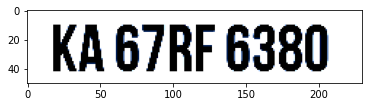

In [93]:
# train data visualization

img = train_dataset[0]['imgs']
lbl_int = train_dataset[0]['targets'] - 1    # 1 is subtracted as it was added during encoding process
label = lbl_enc.inverse_transform(lbl_int)
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
'Image shape: ', img.shape, label

array(['U', 'P', ' ', '5', '3', 'Y', 'Z', ' ', '6', '6', '2', '4'],
      dtype='<U1')

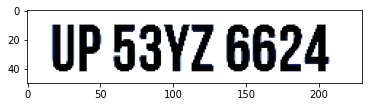

In [94]:
# test data visualiztion

img = test_dataset[0]['imgs']
lbl_int = test_dataset[0]['targets'] - 1 # 
label = lbl_enc.inverse_transform(lbl_int)
plt.imshow(img.permute(1, 2, 0))
label

In [95]:
# model, optimizer & schedular

model = PlateRecognizer(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer_name = 'Adam'
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=4, verbose=True
)
schedular_name = 'ReduceLROnPlateau'



In [96]:
# actual training
loss = {'train': [], 'valid': []}
accuracy = {'character': [], 'label': []}
epoch_count = 0

def run_training(model, train_loader, test_loader, optimizer, schedular, lbl_enc):
    global epoch_count
    for epoch in range(epoch_count, EPOCHS):
        train_loss = train_fn(model, train_loader, optimizer)
        valid_preds, valid_loss = eval_fn(model, test_loader, optimizer)
        
        valid_plate_preds = []
        for vp in valid_preds:
            current_preds = decode_predictions(vp, lbl_enc, False)
            valid_plate_preds.extend(current_preds)
            
        combined = list(zip(test_orig_targets, valid_plate_preds))
            
        char_acc = char_accuracy(test_orig_targets, valid_plate_preds)
        label_acc = label_accuracy(test_orig_targets, valid_plate_preds)
            
        # calculate accuracy of model and log it   
        pprint(combined[:10])
        print(f"Epoch:{epoch}, train_loss:{train_loss}, valid_loss={valid_loss}")
        print(f"char_accuracy:{char_acc}, label_accuracy:{label_acc}")
        
        loss['train'].append(train_loss)
        loss['valid'].append(valid_loss)
        accuracy['character'].append(char_acc)
        accuracy['label'].append(label_acc)
        
        epoch_count += 1
        schedular.step(valid_loss)


# Resume Training
Execute following cells only if you want to resume previously trained model.

In [ ]:
# copy & paste files path of weights.pth & optimizer.pth

STATE_PATH = '../train/harshad/text_recognition-ver-11.0.pth'    # text-recognition-ver-X.X.pth

In [ ]:
# loads model and optimzer

checkpoint = torch.load(STATE_PATH)
LR = checkpoint['lr']
model = checkpoint['model']
epoch_count = checkpoint['train_epoch']
model.load_state_dict(checkpoint['model_state_dict'])

if checkpoint['optimizer_name'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
if checkpoint['scheduler_name'] == 'ReduceLROnPlateau':
    schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.8, patience=5, verbose=True
    )
    schedular.load_state_dict(checkpoint['scheduler_state_dict'])

loss = checkpoint['loss']
accuracy = checkpoint['accuracy']
'comment: '+ checkpoint['comment']

In [37]:
print('LR: ', LR,'\nTrained_epoch_count: ', epoch_count, '\nEPOCHS: ', EPOCHS)

LR:  0.0001 
Trained_epoch_count:  50 
EPOCHS:  100


Change **EPOCH** such that **EPOCH > epoch_count**

In [ ]:
plt.title('LOSS: Train vs Valid')
plt.plot(loss['train'])
plt.plot(loss['valid'])
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
plt.title('Accuracy: Character vs Label')
plt.plot(accuracy['character'])
plt.plot(accuracy['label'])
plt.legend(['character', 'label'])
plt.show()

# Start Training 

In [ ]:
run_training(model, train_loader, test_loader, optimizer, schedular, lbl_enc);

  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`````````````````````````````````````````````````````````'),
 ('MH 66AP 5021', '`````````````````````````````````````````````````````````'),
 ('WB 52BG 3443', '`````````````````````````````````````````````````````````'),
 ('RJ 37SL 6986', '`````````````````````````````````````````````````````````'),
 ('DL 02SJ 7837', '`````````````````````````````````````````````````````````'),
 ('AP 00SV 7991', '`````````````````````````````````````````````````````````'),
 ('MH 20JI 1356', '`````````````````````````````````````````````````````````'),
 ('TR 01NI 6843', '`````````````````````````````````````````````````````````'),
 ('ML 30NZ 6569', '`````````````````````````````````````````````````````````'),
 ('MH 35XH 5779', '`````````````````````````````````````````````````````````')]
Epoch:0, train_loss:4.774274331685399, valid_loss=3.4383386899759105
char_accuracy:0.0, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`````````````````````````````````````````````````````````'),
 ('MH 66AP 5021', '`````````````````````````````````````````````````````````'),
 ('WB 52BG 3443', '`````````````````````````````````````````````````````````'),
 ('RJ 37SL 6986', '`````````````````````````````````````````````````````````'),
 ('DL 02SJ 7837', '`````````````````````````````````````````````````````````'),
 ('AP 00SV 7991', '`````````````````````````````````````````````````````````'),
 ('MH 20JI 1356', '`````````````````````````````````````````````````````````'),
 ('TR 01NI 6843', '`````````````````````````````````````````````````````````'),
 ('ML 30NZ 6569', '`````````````````````````````````````````````````````````'),
 ('MH 35XH 5779', '`````````````````````````````````````````````````````````')]
Epoch:1, train_loss:3.408449533362643, valid_loss=3.4173185674993842
char_accuracy:0.0, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`````````````````````````````````````````````````````````'),
 ('MH 66AP 5021', '`````````````````````````````````````````````````````````'),
 ('WB 52BG 3443', '`````````````````````````````````````````````````````````'),
 ('RJ 37SL 6986', '`````````````````````````````````````````````````````````'),
 ('DL 02SJ 7837', '`````````````````````````````````````````````````````````'),
 ('AP 00SV 7991', '`````````````````````````````````````````````````````````'),
 ('MH 20JI 1356', '`````````````````````````````````````````````````````````'),
 ('TR 01NI 6843', '`````````````````````````````````````````````````````````'),
 ('ML 30NZ 6569', '`````````````````````````````````````````````````````````'),
 ('MH 35XH 5779', '`````````````````````````````````````````````````````````')]
Epoch:2, train_loss:3.396631157770378, valid_loss=3.4092097518680333
char_accuracy:0.0, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`````````````````````````````````````````````````````````'),
 ('MH 66AP 5021', '`````````````````````````````````````````````````````````'),
 ('WB 52BG 3443', '`````````````````````````````````````````````````````````'),
 ('RJ 37SL 6986', '`````````````````````````````````````````````````````````'),
 ('DL 02SJ 7837', '`````````````````````````````````````````````````````````'),
 ('AP 00SV 7991', '`````````````````````````````````````````````````````````'),
 ('MH 20JI 1356', '`````````````````````````````````````````````````````````'),
 ('TR 01NI 6843', '`````````````````````````````````````````````````````````'),
 ('ML 30NZ 6569', '`````````````````````````````````````````````````````````'),
 ('MH 35XH 5779', '`````````````````````````````````````````````````````````')]
Epoch:3, train_loss:3.3904407461364223, valid_loss=3.404786728523873
char_accuracy:0.0, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`````````````````````````````````````````````````````````'),
 ('MH 66AP 5021', '`````````````````````````````````````````````````````````'),
 ('WB 52BG 3443', '`````````````````````````````````````````````````````````'),
 ('RJ 37SL 6986', '`````````````````````````````````````````````````````````'),
 ('DL 02SJ 7837', '`````````````````````````````````````````````````````````'),
 ('AP 00SV 7991', '`````````````````````````````````````````````````````````'),
 ('MH 20JI 1356', '`````````````````````````````````````````````````````````'),
 ('TR 01NI 6843', '`````````````````````````````````````````````````````````'),
 ('ML 30NZ 6569', '`````````````````````````````````````````````````````````'),
 ('MH 35XH 5779', '`````````````````````````````````````````````````````````')]
Epoch:4, train_loss:3.3881820040527066, valid_loss=3.408415296056249
char_accuracy:0.0, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`````````````````````````````````````````````````````````'),
 ('MH 66AP 5021', '`````````````````````````````````````````````````````````'),
 ('WB 52BG 3443', '`````````````````````````````````````````````````````````'),
 ('RJ 37SL 6986', '`````````````````````````````````````````````````````````'),
 ('DL 02SJ 7837', '`````````````````````````````````````````````````````````'),
 ('AP 00SV 7991', '`````````````````````````````````````````````````````````'),
 ('MH 20JI 1356', '`````````````````````````````````````````````````````````'),
 ('TR 01NI 6843', '`````````````````````````````````````````````````````````'),
 ('ML 30NZ 6569', '`````````````````````````````````````````````````````````'),
 ('MH 35XH 5779', '`````````````````````````````````````````````````````````')]
Epoch:5, train_loss:3.3691676107178044, valid_loss=3.2611945341299244
char_accuracy:0.0, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '``` ```````````````````````````````````````````````````` '),
 ('MH 66AP 5021', '``` ```````````````````````````````````````````````````` '),
 ('WB 52BG 3443', '``` ```````````````````````````````````````````````````` '),
 ('RJ 37SL 6986', '``` ```````````````````````````````````````````````````` '),
 ('DL 02SJ 7837', '``` ```````````````````````````````````````````````````` '),
 ('AP 00SV 7991', '``` ```````````````````````````````````````````````````` '),
 ('MH 20JI 1356', '``` ```````````````````````````````````````````````````` '),
 ('TR 01NI 6843', '``` ```````````````````````````````````````````````````` '),
 ('ML 30NZ 6569', '``` ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '``` ```````````````````````````````````````````````````` ')]
Epoch:6, train_loss:2.8871496624096644, valid_loss=2.6747667682063474
char_accuracy:0.16666666666666707, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '``` ```````````````````````````````````````````````````` '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ``````````````````````````````````````````````````MM '),
 ('DL 02SJ 7837', '`MM ``````````````````````````````````````````````````MM '),
 ('AP 00SV 7991', '`MM ``````````````````````````````````````````````````MM '),
 ('MH 20JI 1356', '`HH ``````````````````````````````````````````````````MH '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '``` ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:7, train_loss:2.593721633231172, valid_loss=2.5157410582980595
char_accuracy:0.19633408919123116, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````````````````````````````````````````````MM '),
 ('MH 66AP 5021', '`MM ``````````````````````````````````````````````````MM '),
 ('WB 52BG 3443', '`MM ``````````````````````````````````````````````````MM '),
 ('RJ 37SL 6986', '`MM ``````````````````````````````````````````````````MM '),
 ('DL 02SJ 7837', '`MM ``````````````````````````````````````````````````MM '),
 ('AP 00SV 7991', '`MM ``````````````````````````````````````````````````MM '),
 ('MH 20JI 1356', '`MM ``````````````````````````````````````````````````MM '),
 ('TR 01NI 6843', '`MM ``````````````````````````````````````````````````MM '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````M '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:8, train_loss:2.4654806058812597, valid_loss=2.4770304469374924
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ``````````````````````````````````````````````````MM '),
 ('WB 52BG 3443', '`MM ``````````````````````````````````````````````````MM '),
 ('RJ 37SL 6986', '`MM ``````````````````````````````````````````````````MM '),
 ('DL 02SJ 7837', '`MM ``````````````````````````````````````````````````MM '),
 ('AP 00SV 7991', '`MM ``````````````````````````````````````````````````MM '),
 ('MH 20JI 1356', '`MM ``````````````````````````````````````````````````MM '),
 ('TR 01NI 6843', '`MM ``````````````````````````````````````````````````MM '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````M '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:9, train_loss:2.4403730226307356, valid_loss=2.4587481021881104
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`HH ``````````````````````````````````````````````````MH '),
 ('RJ 37SL 6986', '`HH ``````````````````````````````````````````````````MH '),
 ('DL 02SJ 7837', '`HH ``````````````````````````````````````````````````MH '),
 ('AP 00SV 7991', '`HH ``````````````````````````````````````````````````MH '),
 ('MH 20JI 1356', '`MM ``````````````````````````````````````````````````MM '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````M '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:10, train_loss:2.422279277716999, valid_loss=2.44886352779629
char_accuracy:0.20313681027966646, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````M '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:11, train_loss:2.4128617839390656, valid_loss=2.433669539185258
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````M '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:12, train_loss:2.4050938557281953, valid_loss=2.4166790021432414
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````M '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:13, train_loss:2.394627907244941, valid_loss=2.4141380206958667
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:14, train_loss:2.3859300894319473, valid_loss=2.407235590187279
char_accuracy:0.19954648526077, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:15, train_loss:2.383362376077658, valid_loss=2.416803407239484
char_accuracy:0.19926303854875183, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:16, train_loss:2.3763956209684065, valid_loss=2.40409889307108
char_accuracy:0.19926303854875183, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`HH ```````````````````````````````````````````````````H '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:17, train_loss:2.3693234997333477, valid_loss=2.399687859389159
char_accuracy:0.19850718065003684, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:18, train_loss:2.3668353384715193, valid_loss=2.3963069421751007
char_accuracy:0.19935752078609126, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:19, train_loss:2.3601690013363044, valid_loss=2.3942560913326503
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:20, train_loss:2.3575068970341215, valid_loss=2.385313944773631
char_accuracy:0.19916855631141248, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`HH ```````````````````````````````````````````````````H '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:21, train_loss:2.3583696018172895, valid_loss=2.3838077171428784
char_accuracy:0.19850718065003684, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`HH ```````````````````````````````````````````````````H '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:22, train_loss:2.3564959527982805, valid_loss=2.388761348552532
char_accuracy:0.19860166288737624, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:23, train_loss:2.3502251691328433, valid_loss=2.3855968638583347
char_accuracy:0.1994520030234306, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`HH ```````````````````````````````````````````````````H '),
 ('TR 01NI 6843', '`HH ```````````````````````````````````````````````````H '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:24, train_loss:2.3516200325880408, valid_loss=2.3793993554673754
char_accuracy:0.19916855631141253, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:25, train_loss:2.3478611593640224, valid_loss=2.377496317700223
char_accuracy:0.19935752078609126, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:26, train_loss:2.3420294070652004, valid_loss=2.35885502196647
char_accuracy:0.2004913076341638, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:27, train_loss:2.344391411524885, valid_loss=2.369707253602174
char_accuracy:0.20058578987150313, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:28, train_loss:2.3431788191934606, valid_loss=2.36256303013982
char_accuracy:0.20030234315948506, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`HH ```````````````````````````````````````````````````H '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:29, train_loss:2.3330028666950544, valid_loss=2.361611342644906
char_accuracy:0.19982993197278814, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````WM ')]
Epoch:30, train_loss:2.3328533160602456, valid_loss=2.3558728608999164
char_accuracy:0.20115268329553945, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:31, train_loss:2.331160224336392, valid_loss=2.3568753272563487
char_accuracy:0.20096371882086075, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:32, train_loss:2.3234936307444194, valid_loss=2.3439448201978528
char_accuracy:0.20096371882086075, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:33, train_loss:2.321427447077971, valid_loss=2.333226964280412
char_accuracy:0.20115268329553948, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:34, train_loss:2.3040992480150284, valid_loss=2.3226538907300243
char_accuracy:0.20493197278911468, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:35, train_loss:2.2906902379019622, valid_loss=2.3128054034602537
char_accuracy:0.21003401360544122, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````1```````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````M ')]
Epoch:36, train_loss:2.2891725322150993, valid_loss=2.3193572985159383
char_accuracy:0.21608087679516147, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`HH ```````````````````````````````````````````````````H '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:37, train_loss:2.285033615694305, valid_loss=2.318251221029608
char_accuracy:0.21419123204837393, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````````````````````1``````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:38, train_loss:2.284392110290604, valid_loss=2.312883235312797
char_accuracy:0.21608087679516141, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````````````````````1``````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:39, train_loss:2.277231262049526, valid_loss=2.289546010730503
char_accuracy:0.2176870748299308, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:40, train_loss:2.274019465825829, valid_loss=2.291845950994406
char_accuracy:0.21797052154194912, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:41, train_loss:2.2726521618056514, valid_loss=2.2942318529696077
char_accuracy:0.21806500377928847, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:42, train_loss:2.2740129437691494, valid_loss=2.2865114254994436
char_accuracy:0.21494708994708897, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:43, train_loss:2.2692678875073207, valid_loss=2.283735820838997
char_accuracy:0.21494708994708908, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:44, train_loss:2.2651045682567124, valid_loss=2.279645296904418
char_accuracy:0.22004913076341545, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:45, train_loss:2.2638162951935215, valid_loss=2.276799474750553
char_accuracy:0.21967120181405791, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:46, train_loss:2.261135742383421, valid_loss=2.2693716212435886
char_accuracy:0.21655328798185844, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:47, train_loss:2.2579632825841838, valid_loss=2.272090295413593
char_accuracy:0.21797052154194912, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:48, train_loss:2.257559777506649, valid_loss=2.2815525467331343
char_accuracy:0.22146636432350605, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:49, train_loss:2.255541858596264, valid_loss=2.262792441222045
char_accuracy:0.21872637944066414, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:50, train_loss:2.2509689026128608, valid_loss=2.254743395624934
char_accuracy:0.22146636432350628, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:51, train_loss:2.237804165779644, valid_loss=2.259858248470066
char_accuracy:0.23365457294028621, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`HH ```````````````````````````````````````````````````H '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`HH ```````````````````````````````````````````````````` ')]
Epoch:52, train_loss:2.23196000202905, valid_loss=2.255136206343367
char_accuracy:0.23412698412698313, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:53, train_loss:2.224436336173512, valid_loss=2.2426999517389246
char_accuracy:0.22987528344671102, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:54, train_loss:2.2179882560011603, valid_loss=2.234263355667527
char_accuracy:0.23847316704459465, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ```````````````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:55, train_loss:2.2219961573110005, valid_loss=2.2303091094300553
char_accuracy:0.24414210128495753, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````0``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ```````````````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ```````````````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:56, train_loss:2.2173229202643143, valid_loss=2.241270794524803
char_accuracy:0.2625661375661371, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ``````````0````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:57, train_loss:2.209633722886338, valid_loss=2.2340596441750056
char_accuracy:0.2666288737717305, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ``````````0````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ``````````````````````````````````````````````````W` ')]
Epoch:58, train_loss:2.205455157932078, valid_loss=2.2128659765999594
char_accuracy:0.26861300075585753, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:59, train_loss:2.190453109664379, valid_loss=2.2103220041807705
char_accuracy:0.274187452758881, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ```````````````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM ``````````0````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:60, train_loss:2.176460054585821, valid_loss=2.189026256939312
char_accuracy:0.27135298563869975, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ```````````````````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ```````````````````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:61, train_loss:2.1681903319776596, valid_loss=2.173604658058098
char_accuracy:0.28004535147392295, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:62, train_loss:2.1469213661230344, valid_loss=2.165339713698035
char_accuracy:0.2932728647014362, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ```````````````````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:63, train_loss:2.1376898341548647, valid_loss=2.1539660144496606
char_accuracy:0.3044217687074831, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````3``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:64, train_loss:2.1292203611957823, valid_loss=2.134755118473156
char_accuracy:0.3121693121693125, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````3``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:65, train_loss:2.113411873368938, valid_loss=2.119811325459867
char_accuracy:0.3087679516250946, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:66, train_loss:2.115570705342749, valid_loss=2.110654839524278
char_accuracy:0.3182161753590331, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM ```````````````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:67, train_loss:2.0892970447934047, valid_loss=2.0987089582391687
char_accuracy:0.31566515495086966, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`HH ````````````6``````````````````````````````````````H '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````````````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`HH ```````````````````````````````````````````````````` ')]
Epoch:68, train_loss:2.083559875281796, valid_loss=2.0857347808442674
char_accuracy:0.32671957671957724, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6``````````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:69, train_loss:2.068769375243096, valid_loss=2.078034785416749
char_accuracy:0.3319160997732427, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````````````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````````````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:70, train_loss:2.0471580760836723, valid_loss=2.062752787057344
char_accuracy:0.3371126228269084, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5``````````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00``````````````````````````3`````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2``````````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:71, train_loss:2.0271039100331962, valid_loss=2.029356977961085
char_accuracy:0.3443877551020406, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00``````````````````````````3`````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:72, train_loss:2.001432043788176, valid_loss=1.9843913552997348
char_accuracy:0.35695389266817806, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ```````````````````````````````````````````````````` ')]
Epoch:73, train_loss:1.9706239998040482, valid_loss=1.9465462237865
char_accuracy:0.3589380196523052, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3``````````````````````````````````````` ')]
Epoch:74, train_loss:1.9367031095491316, valid_loss=1.936999172777743
char_accuracy:0.36470143613000733, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00````````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3``````````````````````````````````````` ')]
Epoch:75, train_loss:1.926455213344109, valid_loss=1.9100165990021851
char_accuracy:0.3782123960695385, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:76, train_loss:1.9066981414533695, valid_loss=1.9001298380327654
char_accuracy:0.3831254724111863, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:77, train_loss:1.892296513641949, valid_loss=1.8927999262337212
char_accuracy:0.3909674981103546, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````22```0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:78, train_loss:1.881703252878794, valid_loss=1.885607725865132
char_accuracy:0.3892668178382458, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3``````````````````````````````````````` ')]
Epoch:79, train_loss:1.8743404828289605, valid_loss=1.874793714231199
char_accuracy:0.38095238095238043, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:80, train_loss:1.8607475726385971, valid_loss=1.8638449993219461
char_accuracy:0.38964474678760325, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:81, train_loss:1.8557822192903732, valid_loss=1.8574791964109953
char_accuracy:0.38898337112622766, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````55```3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:82, train_loss:1.8426086014251095, valid_loss=1.8583476747478451
char_accuracy:0.39512471655328735, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:83, train_loss:1.8409706331331803, valid_loss=1.8526511632644378
char_accuracy:0.3908730158730153, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````3`````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:84, train_loss:1.83690798378663, valid_loss=1.8417727045110754
char_accuracy:0.3932350718064998, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````55```3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:85, train_loss:1.8409721251100692, valid_loss=1.8478991512779717
char_accuracy:0.40145502645502606, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ```````````````````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:86, train_loss:1.8350591461463996, valid_loss=1.8338147906569746
char_accuracy:0.39408541194255425, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:87, train_loss:1.8204886732024608, valid_loss=1.8345799746814075
char_accuracy:0.40249433106575944, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````55```3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:88, train_loss:1.830908819627906, valid_loss=1.8263512291349806
char_accuracy:0.3961640211640207, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````55```3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3```````````````````5`````````````````W` ')]
Epoch:89, train_loss:1.824788380485527, valid_loss=1.836471209654937
char_accuracy:0.4064625850340131, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````5````3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3``````````````````````````````````````` ')]
Epoch:90, train_loss:1.827551908483438, valid_loss=1.822313996048661
char_accuracy:0.392668178382464, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````55```3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3`````````````````````````````````````W` ')]
Epoch:91, train_loss:1.8200650367611966, valid_loss=1.8192597982045766
char_accuracy:0.3948412698412693, label_accuracy:0.0


  0%|          | 0/993 [00:00<?, ?it/s]

[('UP 53YZ 6624', '`MM ``````````55```3```````````````````````````````````M '),
 ('MH 66AP 5021', '`MM ````````````6````6`````````````````````````````````M '),
 ('WB 52BG 3443', '`MM ````````````5````2`````````````````````````````````M '),
 ('RJ 37SL 6986', '`MM `````````33````````````````````````````````````````M '),
 ('DL 02SJ 7837', '`MM `````````00```2````````````````````````````````````M '),
 ('AP 00SV 7991', '`MM ``````````0````0```````````````````````````````````M '),
 ('MH 20JI 1356', '`MM ````````````2````0`````````````````````````````````M '),
 ('TR 01NI 6843', '`MM ``````````0````1```````````````````````````````````M '),
 ('ML 30NZ 6569', '`MM ````````````3``````````````````````````````````````` '),
 ('MH 35XH 5779', '`MM ````````````3``````````````````````````````````````` ')]
Epoch:92, train_loss:1.820692698641006, valid_loss=1.819536805152893
char_accuracy:0.400415721844293, label_accuracy:0.0


 37%|███▋      | 372/993 [00:07<00:10, 58.30it/s]

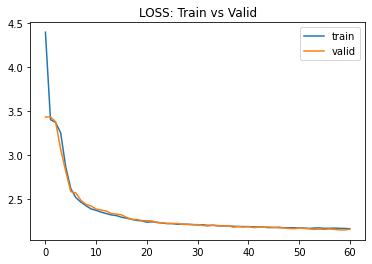

In [69]:
plt.title('LOSS: Train vs Valid')
plt.plot(loss['train'])
plt.plot(loss['valid'])
plt.legend(['train', 'valid'])
plt.show()

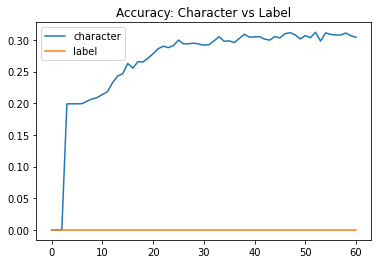

In [70]:
plt.title('Accuracy: Character vs Label')
plt.plot(accuracy['character'])
plt.plot(accuracy['label'])
plt.legend(['character', 'label'])
plt.show()

# Save Data

In [41]:
TRAIN_DIR = os.path.join('..','train')

try:
    os.mkdir(TRAIN_DIR)
except FileExistsError:
    pass

In [42]:
TRAINER_DIR = os.path.join(TRAIN_DIR,'harshad')    # change this

try:
    os.mkdir(TRAINER_DIR)
except FileExistsError:
    pass

In [43]:
# change this for every training
# or it will overwrite your previous data

VER_FILE = os.path.join('text_recognition-ver-16.0.pth')

comment = 'RNN input parameter reduced'

In [44]:
# save state
torch.save(
    {'lr': LR,
    'train_epoch': epoch_count,
    'model': PlateRecognizer(num_chars=len(lbl_enc.classes_)),
    'model_state_dict': model.state_dict(),
    'optimizer_name': optimizer_name,
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': schedular.state_dict(),
    'scheduler_name': schedular_name,
    'loss': loss,
    'accuracy': accuracy,
    'comment':comment},
    VER_FILE
)

# jovian commit

In [37]:
!pip install jovian

     |████████████████████████████████| 68 kB 662 kB/s eta 0:00:01
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6501 sha256=d427e8a85ad8c56be93cf109808dda0eededf297efa0920dc3d403c481cda52a
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [38]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project="text-recognition")

In [45]:
!ls

__notebook_source__.ipynb  text_recognition-ver-15.0.pth
